In [365]:
# Import necessary modules
import numpy as np
from datetime import datetime, timedelta
from pyproj import Proj
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import COASTLINE, BORDERS, STATES
import xarray as xr
import scipy.interpolate
from scipy.interpolate import NearestNDInterpolator
import matplotlib.ticker as ticker
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata
from scipy.signal import savgol_filter

C = 'TestData1.nc'
Lat = 26.55
Lon = -76.9

In [366]:
# Define Reproject
def reproject(C, Lat, Lon):

    C = xarray.open_dataset(C)
    
    # Scan time
    midpoint = str(C['t'].data)[:-8]
    scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')
    
    # Load the 4 channels and convert to Celsius
    IR = C['CMI_C13'].data - 273.15 
    WVU = C['CMI_C08'].data - 273.15 
    WVM = C['CMI_C09'].data - 273.15
    WVL = C['CMI_C10'].data - 273.15 
    
    # Satellite height
    sat_h = C['goes_imager_projection'].perspective_point_height

    # Satellite longitude
    sat_lon = C['goes_imager_projection'].longitude_of_projection_origin

    # Satellite sweep
    sat_sweep = C['goes_imager_projection'].sweep_angle_axis

    # The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
    # See details here: https://proj4.org/operations/projections/geos.html?highlight=geostationary
    x = C['x'][:] * sat_h
    y = C['y'][:] * sat_h

    # Create a Geostationary projection
    geos_proj = ccrs.Geostationary(central_longitude=sat_lon, satellite_height=sat_h)
    
    # Create a pyproj geostationary map object
    p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

    # Perform cartographic transformation. That is, convert image projection coordinates (x and y)
    # to latitude and longitude values.
    XX, YY = np.meshgrid(x, y)
    lons, lats = p(XX, YY, inverse=True)
    
    # Assign the pixels showing space as a single point in the Gulf of Alaska
    lats[np.isnan(IR) | np.isinf(IR)] = 57
    lons[np.isnan(IR) | np.isinf(IR)] = -152

        # Extents and interpolation for WVU
    extents = C.variables['geospatial_lat_lon_extent']
    minimglat = Lat-6
    maximglat = Lat+6
    minimglon = Lon-6
    maximglon = Lon+6
    res = 0.0179985  # degrees resolution at nadir
    grid = np.meshgrid(np.arange(minimglat, maximglat, res), np.arange(minimglon, maximglon, res))

    lats = lats.flatten()
    lons = lons.flatten()
    WVU = WVU.flatten()
    WVM = WVM.flatten()
    WVL = WVL.flatten()
    IR = IR.flatten()


    IR = IR.flatten()
    floater = (np.greater(lats, minimglat) & np.greater(maximglat, lats) &
               np.greater(lons, minimglon) & np.greater(maximglon, lons) & np.isfinite(IR))

    temps_grid_IR = scipy.interpolate.griddata((lats[floater], lons[floater]), IR[floater], (grid[0], grid[1]))

    # Mask NaN or inf values
    WVU = WVU.flatten()
    floater = (np.greater(lats, minimglat) & np.greater(maximglat, lats) &
               np.greater(lons, minimglon) & np.greater(maximglon, lons) & np.isfinite(WVU))

    temps_grid_wvu = scipy.interpolate.griddata((lats[floater], lons[floater]), WVU[floater], (grid[0], grid[1]))

    # Extents and interpolation for WVL
    WVL = WVL.flatten()
    floater = (np.greater(lats, minimglat) & np.greater(maximglat, lats) &
               np.greater(lons, minimglon) & np.greater(maximglon, lons) & np.isfinite(WVL))

    temps_grid_wvl = scipy.interpolate.griddata((lats[floater], lons[floater]), WVL[floater], (grid[0], grid[1]))

    # Extents and interpolation for WVM
    WVM = WVM.flatten()
    floater = (np.greater(lats, minimglat) & np.greater(maximglat, lats) &
               np.greater(lons, minimglon) & np.greater(maximglon, lons) & np.isfinite(WVM))

    temps_grid_wvm = scipy.interpolate.griddata((lats[floater], lons[floater]), WVM[floater], (grid[0], grid[1]))
    
    latitude = np.arange(minimglat, maximglat, res)
    longitude = np.arange(minimglon, maximglon, res)
    temps_grid_wvu = np.transpose(temps_grid_wvu)
    temps_grid_wvl = np.transpose(temps_grid_wvl)
    temps_grid_wvm = np.transpose(temps_grid_wvm)
    temps_grid_IR = np.transpose(temps_grid_IR)
    
    return latitude, longitude, temps_grid_wvu, temps_grid_wvl, temps_grid_wvm, temps_grid_IR

In [367]:
def CenterTempCollection(temps_grid_IR, temps_grid_WVL, temps_grid_WVM, temps_grid_WVU, Lat, Lon, radius_km=30):
    # Convert the radius from kilometers to degrees
    radius_deg = radius_km / 111.32  # Approximate conversion: 1 degree = 111.32 km

    # Find the indices within the circular neighborhood
    valid_latindices = np.where((np.abs(latitude - Lat) <= radius_deg))
    valid_lonindices = np.where((np.abs(longitude - Lon) <= radius_deg))

    # Extract temperature values within the circular neighborhood
    lat_indices, lon_indices = valid_latindices, valid_lonindices
    IRC_temp = temps_grid_IR[lat_indices, lon_indices].max()
    WVLC_temp = temps_grid_WVL[lat_indices, lon_indices].max()
    WVMC_temp = temps_grid_WVM[lat_indices, lon_indices].max()
    WVUC_temp = temps_grid_WVU[lat_indices, lon_indices].max()

    return IRC_temp, WVLC_temp, WVMC_temp, WVUC_temp

In [368]:
def CDODiameter(temps_grid_IR, Lat, Lon, latitude, longitude):
    # Find the indices corresponding to the given Lat and Lon
    lat_idx = np.argmin(np.abs(latitude - Lat))
    lon_idx = np.argmin(np.abs(longitude - Lon))

    temps_grid_IR = np.nan_to_num(temps_grid_IR, nan=0.0)

    # Convert longitude and latitude to nautical miles
    clon, clat = longitude[lon_idx], latitude[lat_idx]

    # Initialize arrays to store radial average and corresponding distances
    radial_range = 360.0  # in nautical miles
    bin_width = 1.0  # in nautical miles
    radial_bins = np.arange(0, radial_range + bin_width, bin_width)
    radial_average = np.zeros_like(radial_bins)
    distances = np.zeros_like(radial_bins)

    # Create empty lists to store temperatures in each bin
    bin_temperatures = [[] for _ in radial_bins]

    # Loop over latitude and longitude
    for lat_idx, lat in enumerate(latitude):
        for lon_idx, lon in enumerate(longitude):
            # Calculate distance
            x = (lon - clon) * 60 * np.cos(np.radians(clat))
            y = (lat - clat) * 60
            r = np.sqrt(x**2 + y**2)

            # Determine the bin index
            bin_idx = np.digitize([r], radial_bins)[0] - 1  # Subtract 1 to convert to 0-based index

            # Add the temperature to the corresponding bin
            if 0 <= bin_idx < len(radial_bins):
                temperature = temps_grid_IR[lat_idx, lon_idx]
                if np.isfinite(temperature):
                    bin_temperatures[bin_idx].append(temperature)

    # Calculate radial average and distances
    for i, (bin_temps, radial_distance) in enumerate(zip(bin_temperatures, radial_bins)):
        if len(bin_temps) > 0:
            # Calculate radial average
            radial_average[i] = np.mean(bin_temps)
        else:
            # No temperatures found, set radial average to NaN
            radial_average[i] = np.nan

        distances[i] = radial_distance

    # Smooth the data with a running average
    window_size = 5
    radial_average_smoothed = np.convolve(radial_average, np.ones(window_size)/window_size, mode='valid')
    distances_smoothed = distances[:len(radial_average_smoothed)]

    # Check if all radial averages are NaN (no temperatures found)
    if np.all(np.isnan(radial_average_smoothed)):
        print("No temperatures found within the circular region.")
        return None

    # Calculate the derivative of the radial average
    derivative = np.gradient(radial_average_smoothed, distances_smoothed)
    derivative = derivative[:-1]
    distances_smoothed = distances_smoothed[:-1]
    radial_average_smoothed = radial_average_smoothed[:-1]

    # Find the first time the derivative turns positive
    positive_derivative_idx = np.argmax(derivative > 0)

    # Find the second time the second derivative turns negative (after turning positive)
    second_derivative = np.gradient(derivative, distances_smoothed)
    second_derivative = second_derivative[:-1]
    second_negative_derivative_idx = np.argmax(second_derivative[positive_derivative_idx:] < 0) + positive_derivative_idx

    # Mark the CDO Diameter as the position of the second negative derivative
    cdo_diameter = (distances_smoothed[second_negative_derivative_idx]) * 2

    # Plot radial average, the derivative, and the second derivative
    plt.figure(figsize=(18, 5))

    # Plot Temps Grid with Circles for CDO Diameter and Second Negative Derivative
    plt.subplot(1, 3, 1)
    plt.imshow(temps_grid_IR, cmap='viridis', origin='lower', extent=(longitude.min(), longitude.max(), latitude.min(), latitude.max()))
    circle_cdo = plt.Circle((clon, clat), (cdo_diameter / 2)/60, color='red', fill=False, linestyle='--', label='CDO Diameter')
    circle_second_negative_derivative = plt.Circle((clon, clat), (distances_smoothed[second_negative_derivative_idx]/2)/60, color='Temperature Ring', fill=False, linestyle='--', label='Second Negative Derivative')
    plt.gca().add_patch(circle_cdo)
    plt.gca().add_patch(circle_second_negative_derivative)
    plt.title('IR Temperature Data with Circles for CDO Diameter and Temperature Ring')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()

    # Plot Radial Average
    plt.subplot(1, 3, 2)
    plt.plot(distances_smoothed, radial_average_smoothed, label='Radial Average')
    plt.axvline(distances_smoothed[positive_derivative_idx], color='red', linestyle='--', label='Temperature Ring')
    plt.axvline(distances_smoothed[second_negative_derivative_idx], color='green', linestyle='--', label='CDO Diameter')
    plt.title('Radial Average of IR Temperatures (Smoothed)')
    plt.xlabel('Radial Distance (nautical miles)')
    plt.ylabel('Temperature (°C)')
    plt.legend()

    # Plot Derivative
    plt.subplot(1, 3, 3)
    plt.plot(distances_smoothed, derivative, label='Derivative')
    plt.axvline(distances_smoothed[positive_derivative_idx], color='red', linestyle='--', label='Temperature Ring')
    plt.axvline(distances_smoothed[second_negative_derivative_idx], color='green', linestyle='--', label='CDO Diameter')
    plt.title('Derivative of Radial Average')
    plt.xlabel('Radial Distance (nautical miles)')
    plt.ylabel('Temperature Derivative')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return cdo_diameter

In [369]:
def EyeDiameter(temps_grid_IR, Lat, Lon, latitude, longitude, cdo_diameter):
    # Find the indices corresponding to the given Lat and Lon
    lat_idx = np.argmin(np.abs(latitude - Lat))
    lon_idx = np.argmin(np.abs(longitude - Lon))

    temps_grid_IR = np.nan_to_num(temps_grid_IR, nan=0.0)

    # Convert longitude and latitude to nautical miles
    clon, clat = longitude[lon_idx], latitude[lat_idx]

    # Initialize arrays to store radial average and corresponding distances
    radial_range = cdo_diameter / 2  # in nautical miles
    bin_width = 1.0  # in nautical miles
    radial_bins = np.arange(0, radial_range + bin_width, bin_width)
    radial_average = np.zeros_like(radial_bins)
    distances = np.zeros_like(radial_bins)

    # Create empty lists to store temperatures in each bin
    bin_temperatures = [[] for _ in radial_bins]

    # Loop over latitude and longitude
    for lat_idx, lat in enumerate(latitude):
        for lon_idx, lon in enumerate(longitude):
            # Calculate distance
            x = (lon - clon) * 60 * np.cos(np.radians(clat))
            y = (lat - clat) * 60
            r = np.sqrt(x**2 + y**2)

            # Determine the bin index
            bin_idx = np.digitize([r], radial_bins)[0] - 1  # Subtract 1 to convert to 0-based index

            # Add the temperature to the corresponding bin
            if 0 <= bin_idx < len(radial_bins):
                temperature = temps_grid_IR[lat_idx, lon_idx]
                if np.isfinite(temperature):
                    bin_temperatures[bin_idx].append(temperature)

    # Calculate radial average and distances
    for i, (bin_temps, radial_distance) in enumerate(zip(bin_temperatures, radial_bins)):
        if len(bin_temps) > 0:
            # Calculate radial average
            radial_average[i] = np.mean(bin_temps)
        else:
            # No temperatures found, set radial average to NaN
            radial_average[i] = np.nan

        distances[i] = radial_distance

    # Smooth the data with a running average
    window_size = 5
    radial_average_smoothed = np.convolve(radial_average, np.ones(window_size)/window_size, mode='valid')
    distances_smoothed = distances[:len(radial_average_smoothed)]

    # Check if all radial averages are NaN (no temperatures found)
    if np.all(np.isnan(radial_average_smoothed)):
        print("No temperatures found within the circular region.")
        return None

    # Calculate the derivative of the radial average
    distances_smoothed = distances_smoothed[:-1]
    radial_average_smoothed = radial_average_smoothed[:-1]
    derivative = np.gradient(radial_average_smoothed, distances_smoothed)


    # Find the diameter (maximum derivative corresponds to the boundary)
    max_derivative_idx = np.argmin(derivative)
    eye_diameter = 2 * distances_smoothed[max_derivative_idx]

    # Plot radial average and the derivative
    plt.figure(figsize=(12, 5))

    # Plot Radial Average
    plt.subplot(1, 2, 1)
    plt.plot(distances_smoothed, radial_average_smoothed, label='Radial Average')
    plt.axvline(distances_smoothed[max_derivative_idx], color='red', linestyle='--', label='Eye Radius')
    plt.title('Radial Average of IR Temperatures')
    plt.xlabel('Radial Distance (nautical miles)')
    plt.ylabel('Temperature (°C)')
    plt.legend()

    # Plot Derivative
    plt.subplot(1, 2, 2)
    plt.plot(distances_smoothed, derivative, label='Derivative')
    plt.axvline(distances_smoothed[max_derivative_idx], color='red', linestyle='--', label='Eye Radius')
    plt.title('Derivative of Radial Average')
    plt.xlabel('Radial Distance (nautical miles)')
    plt.ylabel('Temperature Derivative')
    plt.legend()

    plt.tight_layout()
    plt.show()

    eyediam_CDOsize = eye_diameter / cdo_diameter
    
    return eye_diameter, eyediam_CDOsize

In [370]:
def CDOSymmetry(temps_grid_IR, Lat, Lon, latitude, longitude, cdo_diameter, eye_diameter):
    # Find the indices corresponding to the given Lat and Lon
    lat_idx = np.argmin(np.abs(latitude - Lat))
    lon_idx = np.argmin(np.abs(longitude - Lon))

    temps_grid_IR = np.nan_to_num(temps_grid_IR, nan=0.0)

    # Convert longitude and latitude to nautical miles
    clon, clat = longitude[lon_idx], latitude[lat_idx]

    # Initialize arrays to store radial average and corresponding distances
    radial_range = cdo_diameter / 2  # in nautical miles
    bin_width = 1.0  # in nautical miles
    radial_bins = np.arange(0, radial_range + bin_width, bin_width)
    distances = np.zeros_like(radial_bins)

    # Create empty lists to store temperatures in each bin
    bin_temperatures = [[] for _ in radial_bins]

    # Loop over latitude and longitude
    for lat_idx, lat in enumerate(latitude):
        for lon_idx, lon in enumerate(longitude):
            # Calculate distance
            x = (lon - clon) * 60 * np.cos(np.radians(clat))
            y = (lat - clat) * 60
            r = np.sqrt(x**2 + y**2)

            # Add the temperature to the corresponding bin
            bin_idx = np.digitize([r], radial_bins)[0] - 1  # Subtract 1 to convert to 0-based index
            if 0 <= bin_idx < len(radial_bins):
                temperature = temps_grid_IR[lat_idx, lon_idx]
                if np.isfinite(temperature):
                    bin_temperatures[bin_idx].append(temperature)

    # Calculate distances
    distances = radial_bins

    # Smooth the data with a running average
    window_size = 5
    bin_temperatures_smoothed = [np.convolve(temps, np.ones(window_size)/window_size, mode='valid') for temps in bin_temperatures]
    distances_smoothed = distances[:len(bin_temperatures_smoothed)]


    # Calculate the average standard deviation of average temperatures between eye radius and CDO radius
    eye_radius_idx = np.argmin(np.abs(distances_smoothed - (eye_diameter / 2)))
    cdo_radius_idx = np.argmin(np.abs(distances_smoothed - (cdo_diameter / 2)))

    # Extract temperatures between eye radius and CDO radius for each bin
    temperatures_between_radii = [temps[eye_radius_idx:cdo_radius_idx+1] for temps in bin_temperatures_smoothed]

    # Calculate the average standard deviation for each bin
    avg_std_dev = [np.mean(np.std(temps)) for temps in temperatures_between_radii]
    avg_std_dev1 = np.nan_to_num(avg_std_dev, nan=0.0)
    avg_std_dev = [np.mean(avg_std_dev1)]
    
    print(avg_std_dev)

    # Plot the average standard deviation
    plt.figure(figsize=(8, 6))
    plt.plot(distances_smoothed, avg_std_dev1, label='Average Standard Deviation')
    plt.axvline(eye_diameter / 2, color='red', linestyle='--', label='Eye Radius')
    plt.axvline(cdo_diameter / 2, color='green', linestyle='--', label='CDO Radius')
    plt.title('Average Standard Deviation of Average Temperatures between Eye and CDO Radii')
    plt.xlabel('Radial Distance (nautical miles)')
    plt.ylabel('Average Standard Deviation of Temperatures')
    plt.legend()
    plt.show()

    return avg_std_dev    

In [371]:
def CDODepth(temps_grid_IR, Lat, Lon, latitude, longitude, cdo_diameter, eye_diameter):
    # Find the indices corresponding to the given Lat and Lon
    lat_idx = np.argmin(np.abs(latitude - Lat))
    lon_idx = np.argmin(np.abs(longitude - Lon))

    temps_grid_IR = np.nan_to_num(temps_grid_IR, nan=0.0)

    # Convert longitude and latitude to nautical miles
    clon, clat = longitude[lon_idx], latitude[lat_idx]

    # Initialize arrays to store radial average and corresponding distances
    radial_range = cdo_diameter / 2  # in nautical miles
    bin_width = 1.0  # in nautical miles
    radial_bins = np.arange(0, radial_range + bin_width, bin_width)
    distances = np.zeros_like(radial_bins)

    # Create empty lists to store temperatures in each bin
    bin_temperatures = [[] for _ in radial_bins]

    # Loop over latitude and longitude
    for lat_idx, lat in enumerate(latitude):
        for lon_idx, lon in enumerate(longitude):
            # Calculate distance
            x = (lon - clon) * 60 * np.cos(np.radians(clat))
            y = (lat - clat) * 60
            r = np.sqrt(x**2 + y**2)

            # Add the temperature to the corresponding bin
            bin_idx = np.digitize([r], radial_bins)[0] - 1  # Subtract 1 to convert to 0-based index
            if 0 <= bin_idx < len(radial_bins):
                temperature = temps_grid_IR[lat_idx, lon_idx]
                if np.isfinite(temperature):
                    bin_temperatures[bin_idx].append(temperature)

    # Calculate distances
    distances = radial_bins

    # Smooth the data with a running average
    window_size = 5
    bin_temperatures_smoothed = [np.convolve(temps, np.ones(window_size)/window_size, mode='valid') for temps in bin_temperatures]
    distances_smoothed = distances[:len(bin_temperatures_smoothed)]
    distances_smoothed = distances_smoothed[:-1]

    # Calculate the integral of radial averages between eye radius and CDO radius
    eye_radius_idx = np.argmin(np.abs(distances_smoothed - (eye_diameter / 2)))
    cdo_radius_idx = np.argmin(np.abs(distances_smoothed - (cdo_diameter / 2)))

    # Extract temperatures between eye radius and CDO radius for each bin
    temperatures_between_radii = [temps[eye_radius_idx:cdo_radius_idx+1] for temps in bin_temperatures_smoothed]

    # Calculate the integral for each bin
    integral_values = [np.trapz(temps) for temps in temperatures_between_radii]
    integral_values = integral_values[:-1]

    # Plot the integral values
    plt.figure(figsize=(8, 6))
    plt.plot(distances_smoothed, integral_values, label='Integral of Radial Averages')
    plt.axvline(eye_diameter / 2, color='red', linestyle='--', label='Eye Radius')
    plt.axvline(cdo_diameter / 2, color='green', linestyle='--', label='CDO Radius')
    plt.title('Integral of Radial Averages between Eye and CDO Radii')
    plt.xlabel('Radial Distance (nautical miles)')
    plt.ylabel('Integral of Radial Averages')
    plt.legend()
    plt.show()

    # Select the last integral value
    cdo_depth = integral_values[-1]

    return cdo_depth


In [372]:
def CDO_temp(temps_grid_IR, Lat, Lon, latitude, longitude, cdo_diameter, eye_diameter):
    # Find the indices corresponding to the given Lat and Lon
    lat_idx = np.argmin(np.abs(latitude - Lat))
    lon_idx = np.argmin(np.abs(longitude - Lon))

    temps_grid_IR = np.nan_to_num(temps_grid_IR, nan=0.0)

    # Convert longitude and latitude to nautical miles
    clon, clat = longitude[lon_idx], latitude[lat_idx]

    # Initialize arrays to store radial average and corresponding distances
    radial_range = cdo_diameter / 2  # in nautical miles
    bin_width = 1.0  # in nautical miles
    radial_bins = np.arange(0, radial_range + bin_width, bin_width)
    radial_average = np.zeros_like(radial_bins)
    distances = np.zeros_like(radial_bins)

    # Create empty lists to store temperatures in each bin
    bin_temperatures = [[] for _ in radial_bins]

    # Create empty lists to store temperatures in each bin
    bin_temperatures = [[] for _ in radial_bins]

    # Loop over latitude and longitude
    for lat_idx, lat in enumerate(latitude):
        for lon_idx, lon in enumerate(longitude):
            # Calculate distance
            x = (lon - clon) * 60 * np.cos(np.radians(clat))
            y = (lat - clat) * 60
            r = np.sqrt(x**2 + y**2)

            # Determine the bin index
            bin_idx = np.digitize([r], radial_bins)[0] - 1  # Subtract 1 to convert to 0-based index

            # Add the temperature to the corresponding bin
            if 0 <= bin_idx < len(radial_bins):
                temperature = temps_grid_IR[lat_idx, lon_idx]
                if np.isfinite(temperature):
                    bin_temperatures[bin_idx].append(temperature)

    # Calculate radial average and distances
    for i, (bin_temps, radial_distance) in enumerate(zip(bin_temperatures, radial_bins)):
        if len(bin_temps) > 0:
            # Calculate radial average
            radial_average[i] = np.mean(bin_temps)
        else:
            # No temperatures found, set radial average to NaN
            radial_average[i] = np.nan

        distances[i] = radial_distance


    # Smooth the data with a running average
    window_size = 5
    radial_average_smoothed = np.convolve(radial_average, np.ones(window_size)/window_size, mode='valid')
    distances_smoothed = distances[:len(radial_average_smoothed)]
    
    # Calculate the first positive derivative index
    first_positive_derivative_idx = np.argmax(np.gradient(radial_average_smoothed, distances_smoothed) > 0)

    # Extract the temperature value at the first positive derivative
    cdo_temp = radial_average_smoothed[first_positive_derivative_idx]

    # Plot the temperatures
    plt.figure(figsize=(8, 6))
    plt.plot(distances_smoothed, radial_average_smoothed, label='Temperature Smoothed')
    plt.axvline(eye_diameter / 2, color='red', linestyle='--', label='Eye Radius')
    plt.axvline(cdo_diameter / 2, color='green', linestyle='--', label='CDO Radius')
    plt.axvline(distances_smoothed[first_positive_derivative_idx], color='blue', linestyle='--', label='First Positive Derivative')
    plt.title('Temperature at First Positive Derivative')
    plt.xlabel('Radial Distance (nautical miles)')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()

    CDOIRDiff = IRC_temp - cdo_temp  
    
    return cdo_temp, CDOIRDiff

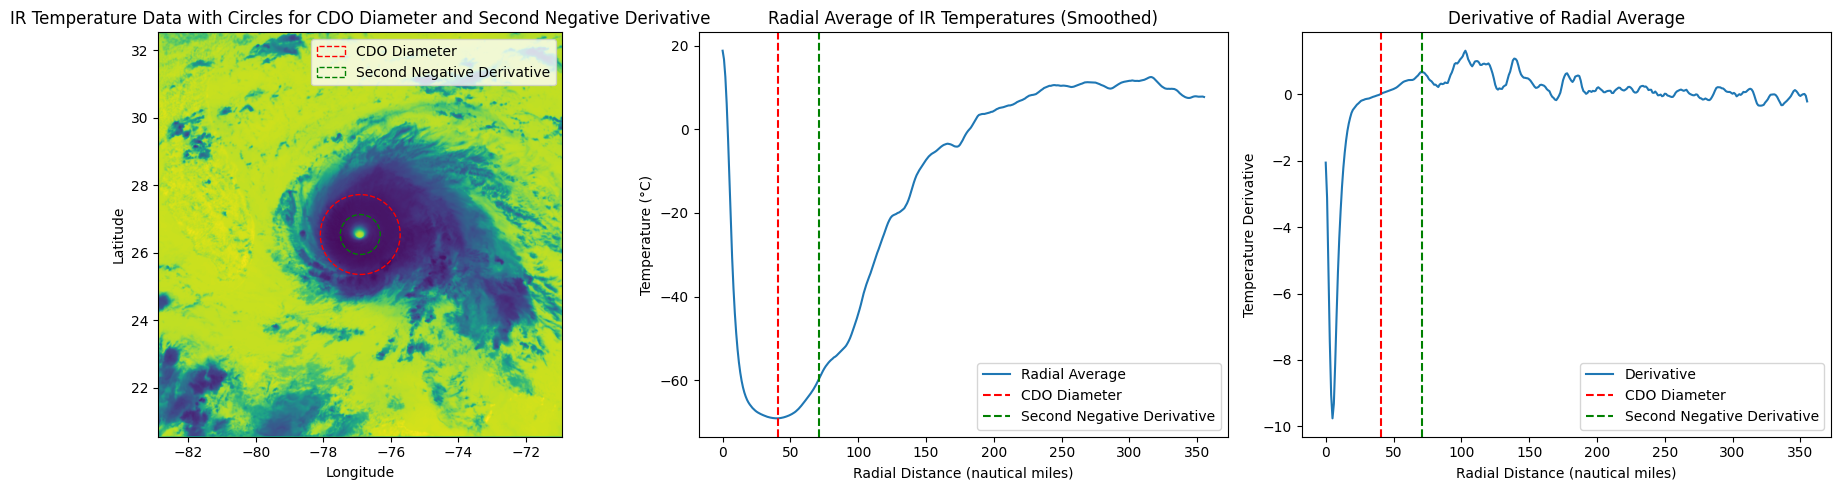

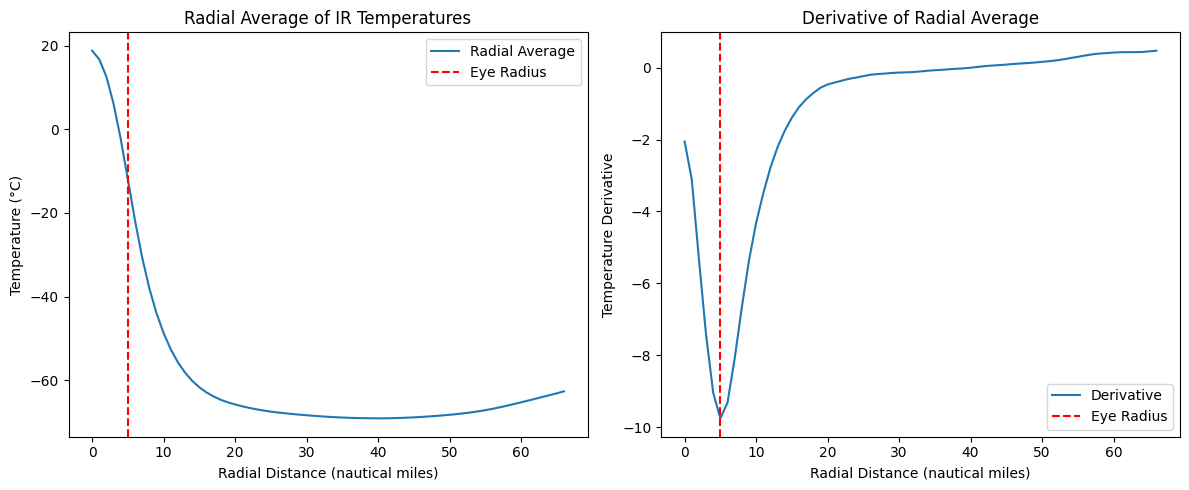

C:\Users\micha\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\micha\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\micha\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[1.9245169184567965]


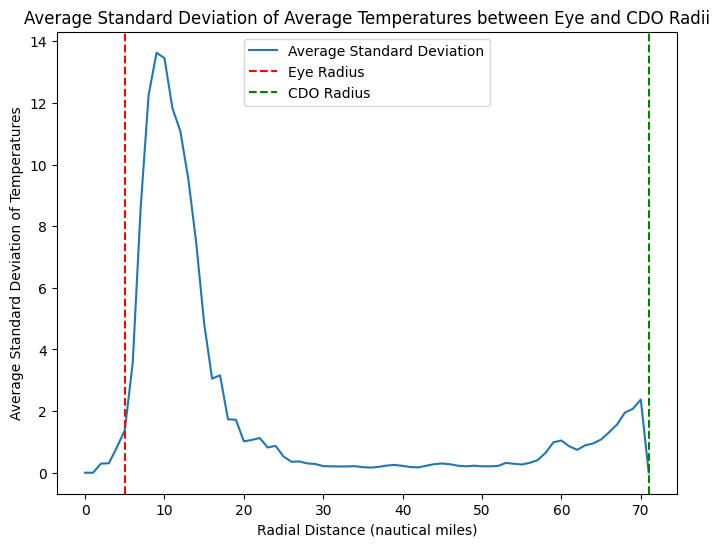

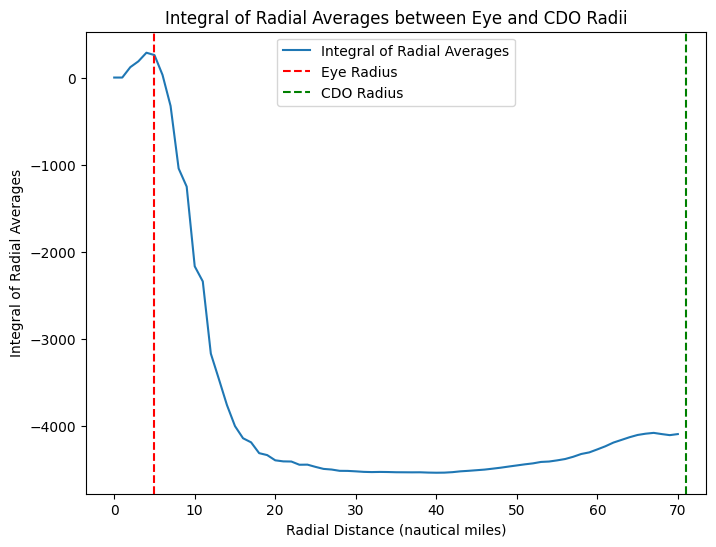

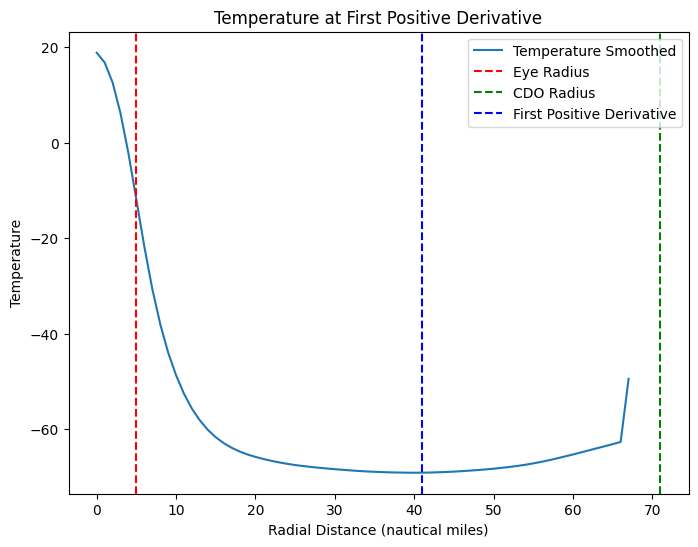

In [374]:
latitude, longitude, temps_grid_wvu, temps_grid_wvl, temps_grid_wvm, temps_grid_IR = reproject(C, Lat, Lon)
IRC_temp, WVLC_temp, WVMC_temp, WVUC_temp = CenterTempCollection(temps_grid_IR, temps_grid_wvl, temps_grid_wvm, temps_grid_wvu, Lat, Lon)
cdo_diameter = CDODiameter(temps_grid_IR, Lat, Lon, latitude, longitude)
eye_diameter, eyediam_CDOsize = EyeDiameter(temps_grid_IR, Lat, Lon, latitude, longitude, cdo_diameter)
avg_std_dev = CDOSymmetry(temps_grid_IR, Lat, Lon, latitude, longitude, cdo_diameter, eye_diameter)
cdo_depth = CDODepth(temps_grid_IR, Lat, Lon, latitude, longitude, cdo_diameter, eye_diameter)
cdo_temp, CDOIRDiff = CDO_temp(temps_grid_IR, Lat, Lon, latitude, longitude, cdo_diameter, eye_diameter)

In [375]:
print(f'IR Temp: {IRC_temp}C')
print(f'Low-Level WV Temp: {WVLC_temp}C')
print(f'Mid-Level WV Temp: {WVMC_temp}C')
print(f'Upper-Level WV Temp: {WVUC_temp}C')
print(f'CDO Diameter: {cdo_diameter} nmi')
print(f'Eye Diameter: {eye_diameter} nmi')
print(f'Eye Diameter/CDO Diameter Ratio: {eyediam_CDOsize}')
print(f'CDO Symmetry: {avg_std_dev}')
print(f'CDO Volume: {cdo_depth} C/nmi^3')
print(f'CDO Temperature: {cdo_temp}C')
print(f'CDO/Eye Temperature Differential: {CDOIRDiff}C')

IR Temp: 20.183996007621992C
Low-Level WV Temp: -2.6389332036130826C
Mid-Level WV Temp: -12.461730286816888C
Upper-Level WV Temp: -20.945008069146606C
CDO Diameter: 142.0 nmi
Eye Diameter: 10.0 nmi
Eye Diameter/CDO Diameter Ratio: 0.07042253521126761
CDO Symmetry: [1.9245169184567965]
CDO Volume: -4093.125630576654 C/nmi^3
CDO Temperature: -69.12524647547849C
CDO/Eye Temperature Differential: 89.30924248310049C
